# UFC Fight Outcome Prediction — Regularized Logistic Regression

Notebook using the **Kaggle UFC dataset**, with:
- Data loading (via `kagglehub`) and merging
- Descriptive statistics & visualizations
- Missingness audit & imputation
- Separate models for male and female fighters
- Regularized logistic regression
- Evaluation (ROC‑AUC, classification report) & interpretation (coefficients, importance plots)

**Research question:** _What are the significant characteristics associated with winning a fight?_

In [ ]:
# --- Setup ---
import os, warnings
warnings.filterwarnings('ignore')

import kagglehub
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    RocCurveDisplay,
)

# Select only most recent fights
RECENT = True

RANDOM_STATE = 42
sns.set(style='whitegrid')

## 1) Download & Load Data

In [ ]:
# Download dataset from Kaggle
path = kagglehub.dataset_download("nickshillito/comprehensive-ufc-data")
print("Path to dataset files:", path)

# CSV paths
event_list_path = os.path.join(path, 'event_list.csv')
event_data_path = os.path.join(path, 'event_data.csv')
fighter_attributes_path = os.path.join(path, 'fighter_attributes.csv')
fighter_history_path = os.path.join(path, 'fighter_history.csv')
fighter_stats_path = os.path.join(path, 'fighter_stats.csv')

# Load
df_event_list = pd.read_csv(event_list_path)
df_event_data = pd.read_csv(event_data_path)
df_fighter_attributes = pd.read_csv(fighter_attributes_path)
df_fighter_history = pd.read_csv(fighter_history_path)
df_fighter_stats = pd.read_csv(fighter_stats_path)

display(df_event_list.head())
display(df_event_data.head())
display(df_fighter_attributes.head())
display(df_fighter_history.head())
display(df_fighter_stats.head())

100%|██████████| 1.97M/1.97M [00:00<00:00, 51.8MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/nickshillito/comprehensive-ufc-data/versions/1


,event_id,event_year,event_name
0,600055175,2025,UFC Fight Night: Qatar
1,600055729,2025,UFC 322: Della Maddalena vs. Makhachev
2,600056160,2025,UFC Fight Night: 11/8
3,600056045,2025,UFC Fight Night: Garcia vs. Onama
4,600055085,2025,UFC 321: Aspinall vs. Gane


,event_id,event_uid,event_name,event_date,fight_id,fight_uid,fight_card,fight_number,weight_class,title_fight,f1_id,f1_uid,f1_name,f2_id,f2_uid,f2_name,fight_winner,fight_completed
0,600055729,s:3301~l:3321~e:600055729,UFC 322,2025-11-15,401817808,s:3301~l:3321~e:600055729~c:401817808,MAIN_CARD,1,WELTERWEIGHT,True,3332412,s:3301~a:3332412,Islam Makhachev,4828707,s:3301~a:4828707,Jack Della Maddalena,NaN,False
1,600055729,s:3301~l:3321~e:600055729,UFC 322,2025-11-15,401817809,s:3301~l:3321~e:600055729~c:401817809,MAIN_CARD,2,W_FLYWEIGHT,True,4350762,s:3301~a:4350762,Zhang Weili,2554705,s:3301~a:2554705,Valentina Shevchenko,NaN,False
2,600055729,s:3301~l:3321~e:600055729,UFC 322,2025-11-15,401817810,s:3301~l:3321~e:600055729~c:401817810,MAIN_CARD,3,WELTERWEIGHT,False,4294832,s:3301~a:4294832,Carlos Prates,3152929,s:3301~a:3152929,Leon Edwards,NaN,False
3,600055729,s:3301~l:3321~e:600055729,UFC 322,2025-11-15,401824585,s:3301~l:3321~e:600055729~c:401824585,MAIN_CARD,4,W_FLYWEIGHT,False,4243624,s:3301~a:4243624,Tracy Cortez,4350796,s:3301~a:4350796,Erin Blanchfield,NaN,False
4,600055729,s:3301~l:3321~e:600055729,UFC 322,2025-11-15,401824586,s:3301~l:3321~e:600055729~c:401824586,MAIN_CARD,5,MIDDLEWEIGHT,False,4690541,s:3301~a:4690541,Gregory Rodrigues,4300149,s:3301~a:4300149,Roman Kopylov,NaN,False


,fighter_id,name,height,weight,age,dob,gender,weight_class,reach,stance,style,gym,country
0,3332412,Islam Makhachev,177.80,70.31,33.0,1991-10-27,male,welterweight,179.07,southpaw,wrestling,eagles mma,russia
1,4350762,Zhang Weili,162.56,52.16,36.0,1989-08-13,female,womens-flyweight,160.02,switch,muay thai,beijing black tiger,china
2,4294832,Carlos Prates,185.42,77.11,32.0,1993-08-17,male,welterweight,198.12,switch,striker,fighting nerds,brazil
3,4243624,Tracy Cortez,165.10,56.70,31.0,1993-12-10,female,womens-flyweight,166.37,orthodox,mixed martial artist,fight ready,usa
4,4690541,Gregory Rodrigues,190.50,83.91,33.0,1992-02-17,male,middleweight,190.50,orthodox,grappling,kill cliff fc,brazil


,uid,fight_id,event_id,event_date,event_name,promotion,fighter_id,fighter_name,fight_result,opponent_id,opponent_name,title_fight,fight_end_round,fight_result_type,fight_duration,over_2_5
0,s:3301~l:3321~e:600051442~c:401751541,600051442-4873640-3028863,600051442,2025-01-18,UFC 311,UFC,3332412,islam makhachev,W,3028863,renato moicano,True,1,SUBMISSION,4.08,False
1,s:3301~l:3321~e:600044413~c:401652641,600044413-4873640-2506549,600044413,2024-06-01,UFC 302,UFC,3332412,islam makhachev,W,2506549,dustin poirier,True,5,SUBMISSION,22.70,True
2,s:3301~l:3321~e:600031832~c:401534648,600031832-3949584-4873640,600031832,2023-10-21,UFC 294,UFC,3332412,islam makhachev,W,3949584,alexander volkanovski,True,1,KO-TKO,3.10,False
3,s:3301~l:3321~e:600025531~c:401498612,600025531-3949584-4873640,600025531,2023-02-11,UFC 284,UFC,3332412,islam makhachev,W,3949584,alexander volkanovski,True,5,DEC-UNA,25.00,True
4,s:3301~l:3321~e:600017767~c:401423650,600017767-4873640-2504169,600017767,2022-10-22,UFC 280,UFC,3332412,islam makhachev,W,2504169,charles oliveira,True,2,SUBMISSION,8.27,False


,uid,fighter_id,SDBL,SDBA,SDB_ACC,SDHL,SDHA,SDH_ACC,SDLL,SDLA,...,SM,TSLL,TSLA,SL_ACC,TSBL,TSBA,SB_ACC,TSHL,TSHA,SH_ACC
0,s:3301~l:3321~e:600051442~c:401751541,3332412,1,2,0.50,4,16,0.25,0,0,...,1,0,0,0.0,1,2,0.50,5,17,0.29
1,s:3301~l:3321~e:600044413~c:401652641,3332412,3,3,1.00,68,132,0.52,0,1,...,2,0,1,0.0,7,7,1.00,81,148,0.55
2,s:3301~l:3321~e:600031832~c:401534648,3332412,2,4,0.50,3,5,0.60,2,2,...,0,2,2,1.0,9,11,0.82,13,16,0.81
3,s:3301~l:3321~e:600025531~c:401498612,3332412,9,11,0.82,33,68,0.49,3,3,...,0,3,3,1.0,18,20,0.90,36,72,0.50
4,s:3301~l:3321~e:600017767~c:401423650,3332412,0,1,0.00,21,30,0.70,0,0,...,1,0,0,0.0,5,6,0.83,25,35,0.71


## 2) Merge & De‑duplicate

In [ ]:
# Merge events
df_merged_events = pd.merge(df_event_list, df_event_data, on='event_id', how='inner')
display(df_merged_events.head())

# De‑duplicate fighter history by uid
dup_before = df_fighter_history.duplicated(subset=['uid']).sum()
df_fighter_history_cleaned = df_fighter_history.drop_duplicates(subset=['uid'], keep='first').copy()
dup_after = df_fighter_history_cleaned.duplicated(subset=['uid']).sum()
print(f"Duplicates before: {dup_before} | after: {dup_after}")

# Merge fighter attributes + cleaned history
df_merged_fighters = pd.merge(df_fighter_attributes, df_fighter_history_cleaned, on='fighter_id', how='inner')

# Merge with fighter_stats
combined_df = pd.merge(df_merged_fighters, df_fighter_stats, on=['uid','fighter_id'], how='inner')
display(combined_df.head())

,event_id,event_year,event_name_x,event_uid,event_name_y,event_date,fight_id,fight_uid,fight_card,fight_number,weight_class,title_fight,f1_id,f1_uid,f1_name,f2_id,f2_uid,f2_name,fight_winner,fight_completed
0,600055729,2025,UFC 322: Della Maddalena vs. Makhachev,s:3301~l:3321~e:600055729,UFC 322,2025-11-15,401817808,s:3301~l:3321~e:600055729~c:401817808,MAIN_CARD,1,WELTERWEIGHT,True,3332412,s:3301~a:3332412,Islam Makhachev,4828707,s:3301~a:4828707,Jack Della Maddalena,NaN,False
1,600055729,2025,UFC 322: Della Maddalena vs. Makhachev,s:3301~l:3321~e:600055729,UFC 322,2025-11-15,401817809,s:3301~l:3321~e:600055729~c:401817809,MAIN_CARD,2,W_FLYWEIGHT,True,4350762,s:3301~a:4350762,Zhang Weili,2554705,s:3301~a:2554705,Valentina Shevchenko,NaN,False
2,600055729,2025,UFC 322: Della Maddalena vs. Makhachev,s:3301~l:3321~e:600055729,UFC 322,2025-11-15,401817810,s:3301~l:3321~e:600055729~c:401817810,MAIN_CARD,3,WELTERWEIGHT,False,4294832,s:3301~a:4294832,Carlos Prates,3152929,s:3301~a:3152929,Leon Edwards,NaN,False
3,600055729,2025,UFC 322: Della Maddalena vs. Makhachev,s:3301~l:3321~e:600055729,UFC 322,2025-11-15,401824585,s:3301~l:3321~e:600055729~c:401824585,MAIN_CARD,4,W_FLYWEIGHT,False,4243624,s:3301~a:4243624,Tracy Cortez,4350796,s:3301~a:4350796,Erin Blanchfield,NaN,False
4,600055729,2025,UFC 322: Della Maddalena vs. Makhachev,s:3301~l:3321~e:600055729,UFC 322,2025-11-15,401824586,s:3301~l:3321~e:600055729~c:401824586,MAIN_CARD,5,MIDDLEWEIGHT,False,4690541,s:3301~a:4690541,Gregory Rodrigues,4300149,s:3301~a:4300149,Roman Kopylov,NaN,False


Duplicates before: 8863 | after: 0


,fighter_id,name,height,weight,age,dob,gender,weight_class,reach,stance,...,SM,TSLL,TSLA,SL_ACC,TSBL,TSBA,SB_ACC,TSHL,TSHA,SH_ACC
0,3332412,Islam Makhachev,177.8,70.31,33.0,1991-10-27,male,welterweight,179.07,southpaw,...,1,0,0,0.0,1,2,0.50,5,17,0.29
1,3332412,Islam Makhachev,177.8,70.31,33.0,1991-10-27,male,welterweight,179.07,southpaw,...,2,0,1,0.0,7,7,1.00,81,148,0.55
2,3332412,Islam Makhachev,177.8,70.31,33.0,1991-10-27,male,welterweight,179.07,southpaw,...,0,2,2,1.0,9,11,0.82,13,16,0.81
3,3332412,Islam Makhachev,177.8,70.31,33.0,1991-10-27,male,welterweight,179.07,southpaw,...,0,3,3,1.0,18,20,0.90,36,72,0.50
4,3332412,Islam Makhachev,177.8,70.31,33.0,1991-10-27,male,welterweight,179.07,southpaw,...,1,0,0,0.0,5,6,0.83,25,35,0.71


## 3) Descriptive Statistics

In [ ]:
# Drop obvious id/name cols for numeric summary
id_like = [c for c in combined_df.columns if ('id' in c.lower())]
drop_for_descr = list(set(['name','fighter_name','opponent_name','uid','event_name','event_date'] + id_like))
descr_df = combined_df.drop(columns=[c for c in drop_for_descr if c in combined_df.columns], errors='ignore')
display(descr_df.info())
display(descr_df.describe().T)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7125 entries, 0 to 7124
Data columns (total 73 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   height             7004 non-null   float64
 1   weight             7008 non-null   float64
 2   age                6976 non-null   float64
 3   dob                6976 non-null   object 
 4   gender             7125 non-null   object 
 5   weight_class       7037 non-null   object 
 6   reach              6911 non-null   float64
 7   stance             7097 non-null   object 
 8   style              5946 non-null   object 
 9   gym                6711 non-null   object 
 10  country            6349 non-null   object 
 11  promotion          7125 non-null   object 
 12  fight_result       7125 non-null   object 
 13  title_fight        7125 non-null   bool   
 14  fight_end_round    7125 non-null   int64  
 15  fight_result_type  7122 non-null   object 
 16  fight_duration     7125 

None

,count,mean,std,min,25%,50%,75%,max
height,7004.0,178.282324,9.211184,152.40,172.72,177.80,185.42,210.82
weight,7008.0,75.226341,16.135057,51.71,61.69,70.76,83.91,136.08
age,6976.0,37.028526,6.294759,19.00,33.00,36.00,41.00,71.00
reach,6911.0,182.941046,11.121163,147.32,175.26,182.88,190.50,214.63
fight_end_round,7125.0,2.351018,1.030222,0.00,1.00,3.00,3.00,5.00
...,...,...,...,...,...,...,...,...
TSBA,7125.0,11.774035,12.635566,0.00,2.00,8.00,17.00,133.00
SB_ACC,7125.0,0.624996,0.318590,0.00,0.50,0.69,0.86,1.00
TSHL,7125.0,26.474807,24.624293,0.00,8.00,20.00,38.00,274.00
TSHA,7125.0,68.177123,60.671891,0.00,22.00,53.00,98.00,553.00


## 4) Visualizations

Available for plotting: ['height', 'weight', 'age', 'reach', 'TSL', 'TSA', 'SS_ACC', 'TDL', 'TDA', 'TD_ACC', 'KD', 'SM', 'fight_duration']


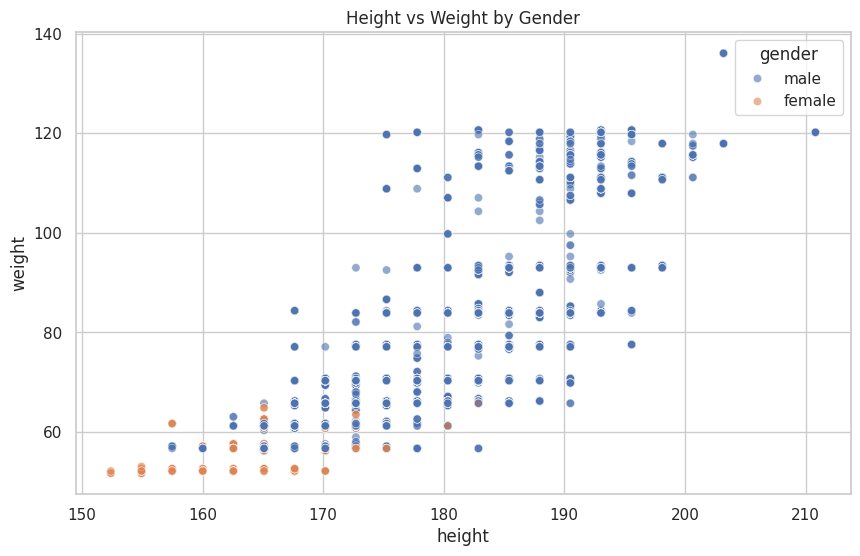

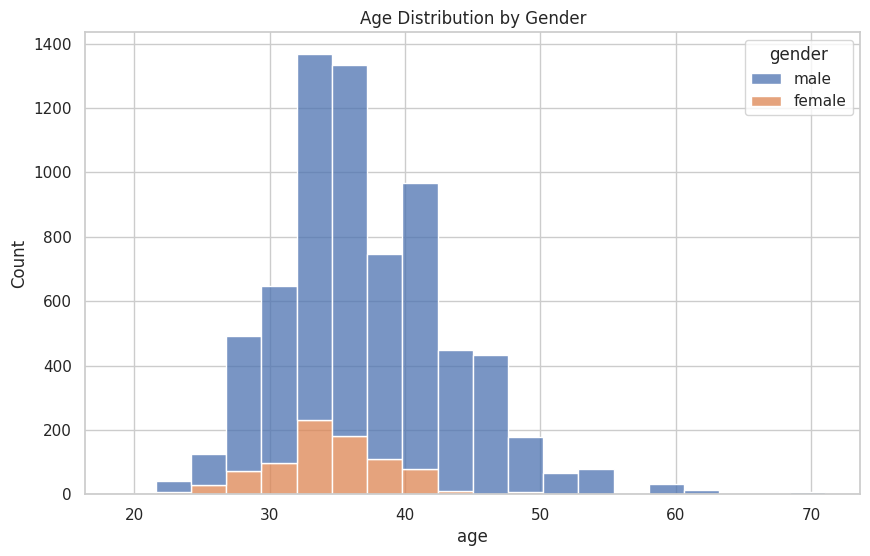

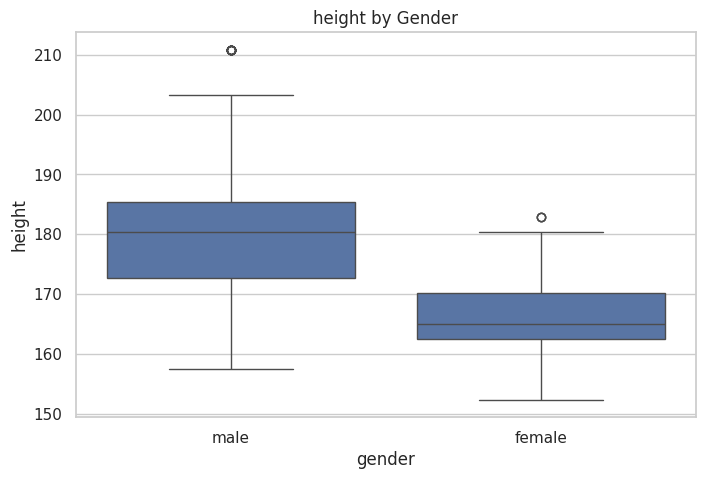

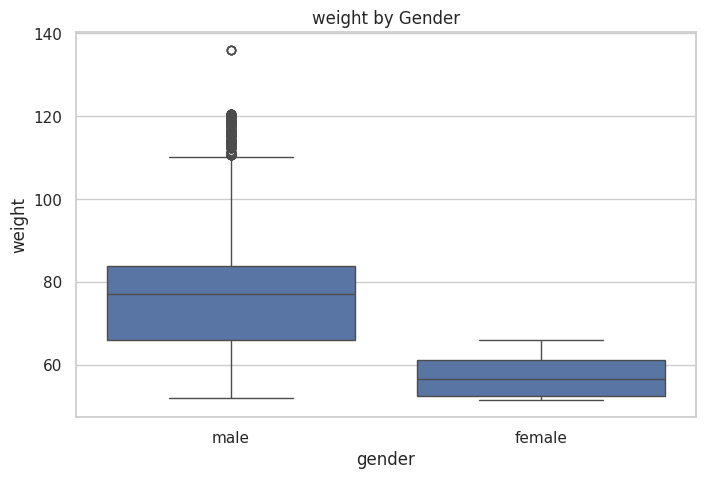

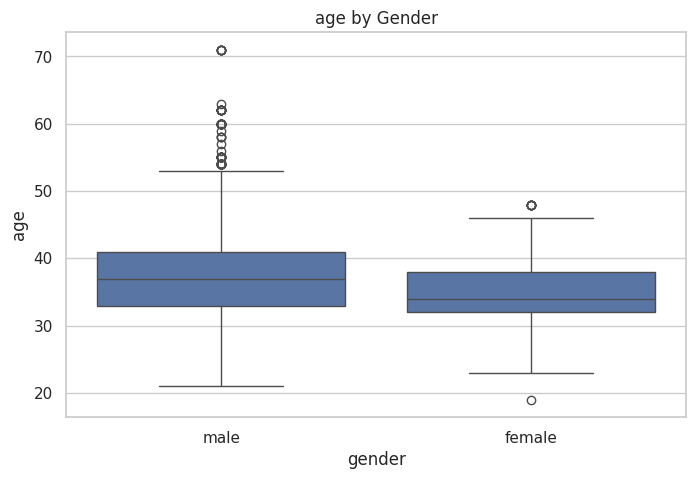

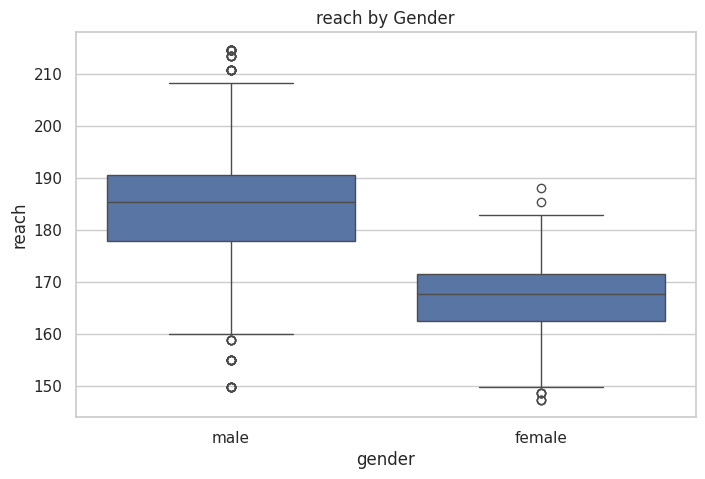

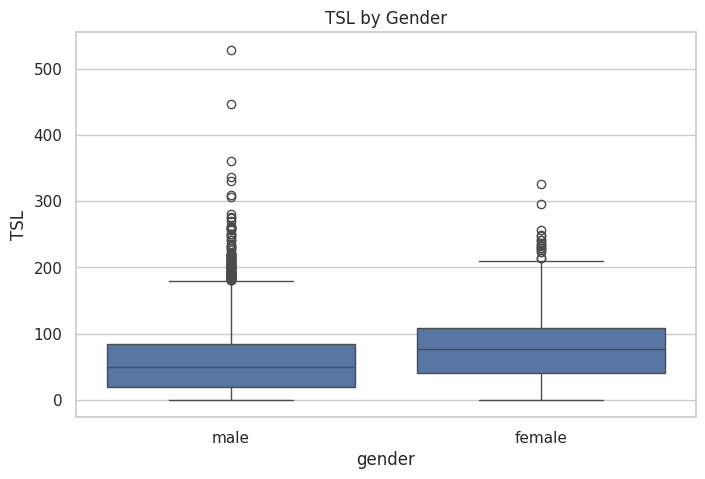

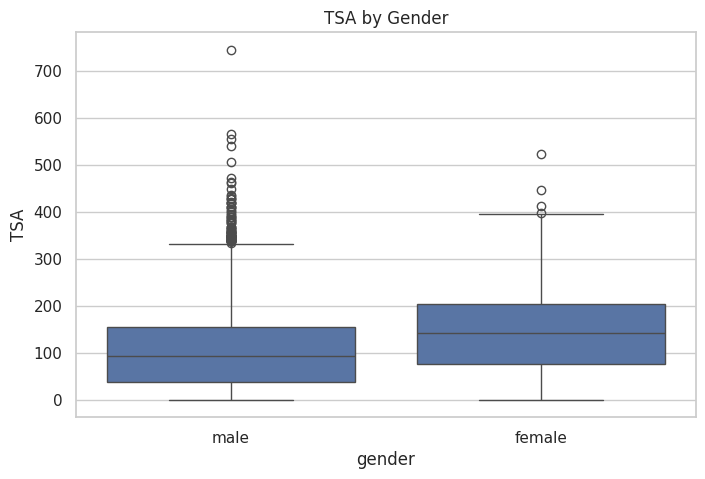

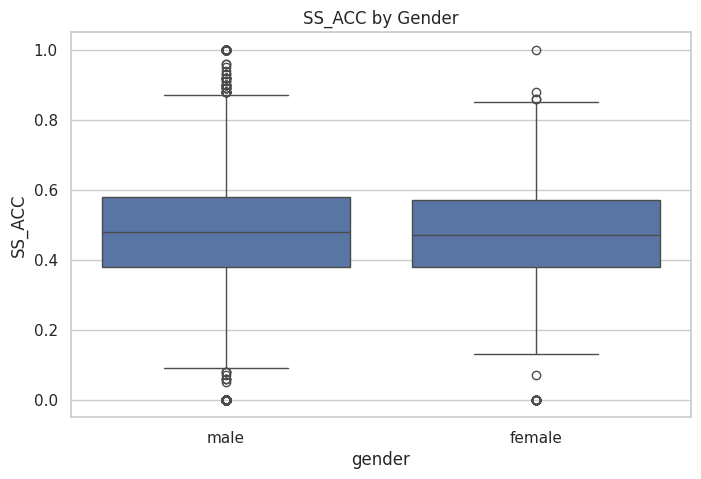

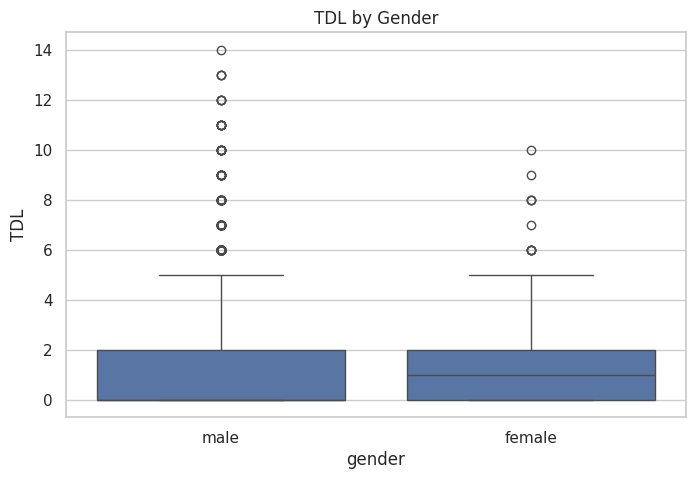

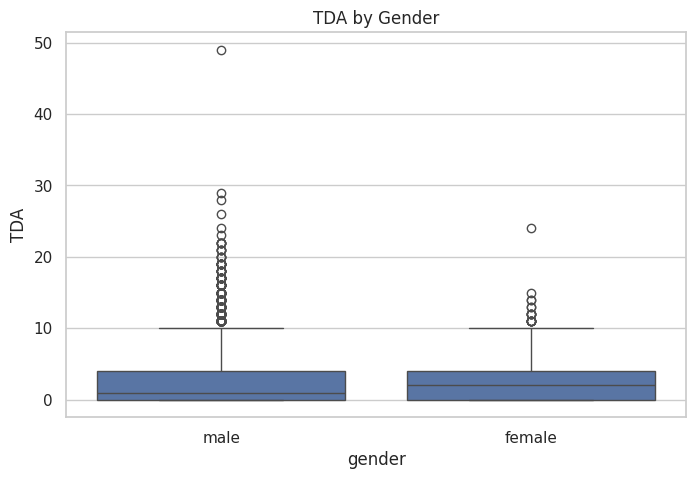

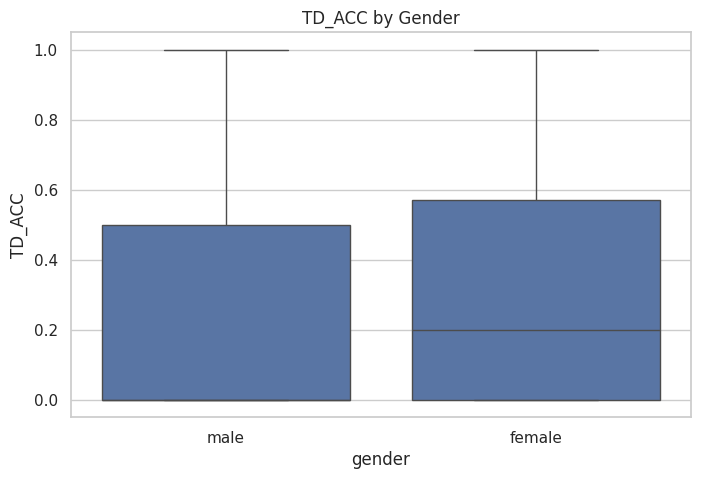

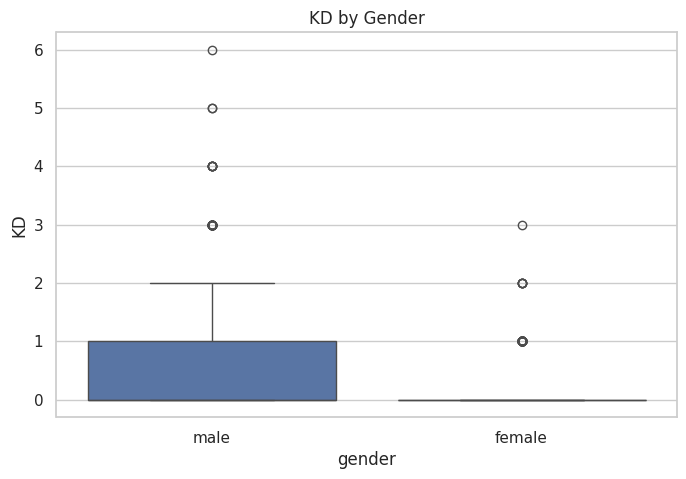

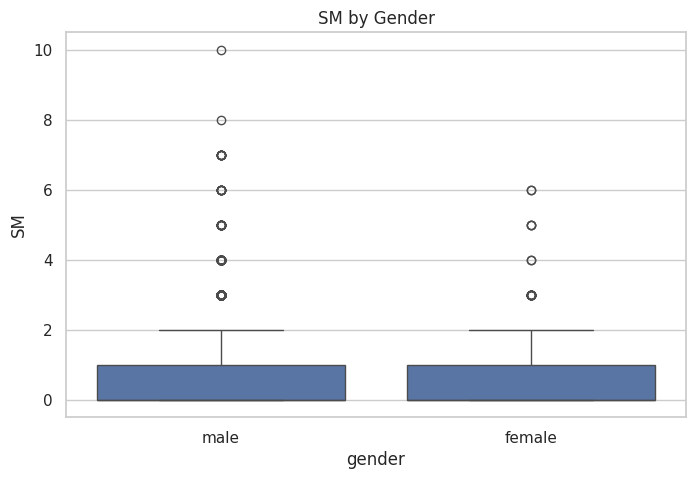

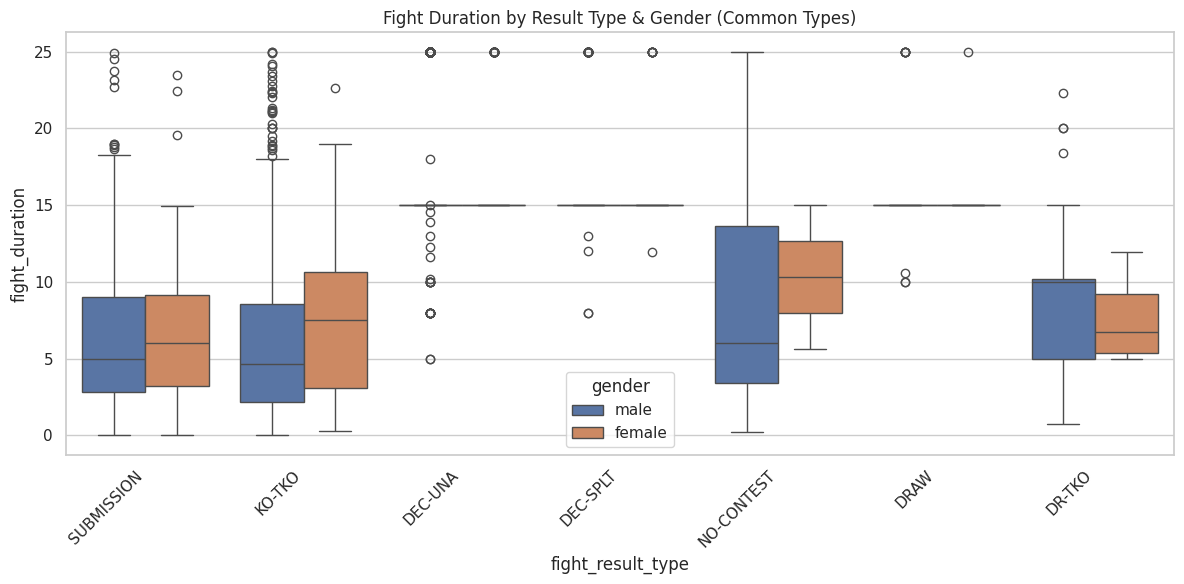

In [ ]:
# Select some sensible numeric columns if present
selected_columns = ['height','weight','age','reach','TSL','TSA','SS_ACC','TDL','TDA','TD_ACC','KD','SM','fight_duration']
available = [c for c in selected_columns if c in combined_df.columns]
print('Available for plotting:', available)

if 'gender' in combined_df.columns:
    # Scatter: height vs weight by gender
    if all(c in combined_df.columns for c in ['height','weight']):
        plt.figure(figsize=(10,6))
        sns.scatterplot(data=combined_df, x='height', y='weight', hue='gender', alpha=0.6)
        plt.title('Height vs Weight by Gender')
        plt.show()

    # Histogram: age by gender
    if 'age' in combined_df.columns:
        plt.figure(figsize=(10,6))
        sns.histplot(data=combined_df.dropna(subset=['age','gender']), x='age', hue='gender', multiple='stack', bins=20)
        plt.title('Age Distribution by Gender')
        plt.show()

    # Boxplots for selected numerics by gender
    for col in available:
        if col != 'fight_duration':
            plt.figure(figsize=(8,5))
            sns.boxplot(data=combined_df.dropna(subset=[col,'gender']), x='gender', y=col)
            plt.title(f'{col} by Gender')
            plt.show()

    # Fight duration by result type (common categories)
    if all(c in combined_df.columns for c in ['fight_result_type','fight_duration','gender']):
        counts = combined_df['fight_result_type'].value_counts()
        keep_types = counts[counts >= 50].index.tolist()
        if keep_types:
            plt.figure(figsize=(12,6))
            dfp = combined_df[combined_df['fight_result_type'].isin(keep_types)]
            sns.boxplot(data=dfp.dropna(subset=['fight_duration','fight_result_type','gender']), x='fight_result_type', y='fight_duration', hue='gender')
            plt.title('Fight Duration by Result Type & Gender (Common Types)')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.show()
else:
    print("'gender' column not found — skipping gender‑based plots.")

## 5) Missingness Audit & Imputation

In [ ]:
def missing_overview(df, top=20):
    n = len(df)
    miss = df.isna().sum().sort_values(ascending=False)
    summary = pd.DataFrame({
        'missing_count': miss,
        'missing_pct': (miss / n * 100).round(2)
    })
    display(summary.head(top))
    print(f"Cols w/ missing: {(summary['missing_count']>0).sum()} | Rows w/ any missing: {df.isna().any(axis=1).sum()}")
    return summary

missing_summary = missing_overview(combined_df, top=20)

# Impute numerics with median; categoricals with mode (or 'Missing' if no mode)
num_cols = combined_df.select_dtypes(include=np.number).columns
cat_cols = combined_df.select_dtypes(include='object').columns

for c in num_cols:
    if combined_df[c].isna().any():
        combined_df[c] = combined_df[c].fillna(combined_df[c].median())

for c in cat_cols:
    if combined_df[c].isna().any():
        mode = combined_df[c].mode()
        combined_df[c] = combined_df[c].fillna(mode.iloc[0] if not mode.empty else 'Missing')

print('Total missing after imputation:', int(combined_df.isna().sum().sum()))

,missing_count,missing_pct
style,1179,16.55
country,776,10.89
gym,414,5.81
reach,214,3.00
age,149,2.09
dob,149,2.09
height,121,1.70
weight,117,1.64
weight_class,88,1.24
stance,28,0.39


Cols w/ missing: 11 | Rows w/ any missing: 1291
Total missing after imputation: 0


## 6) Multicollinearity (pre‑model diagnostic)

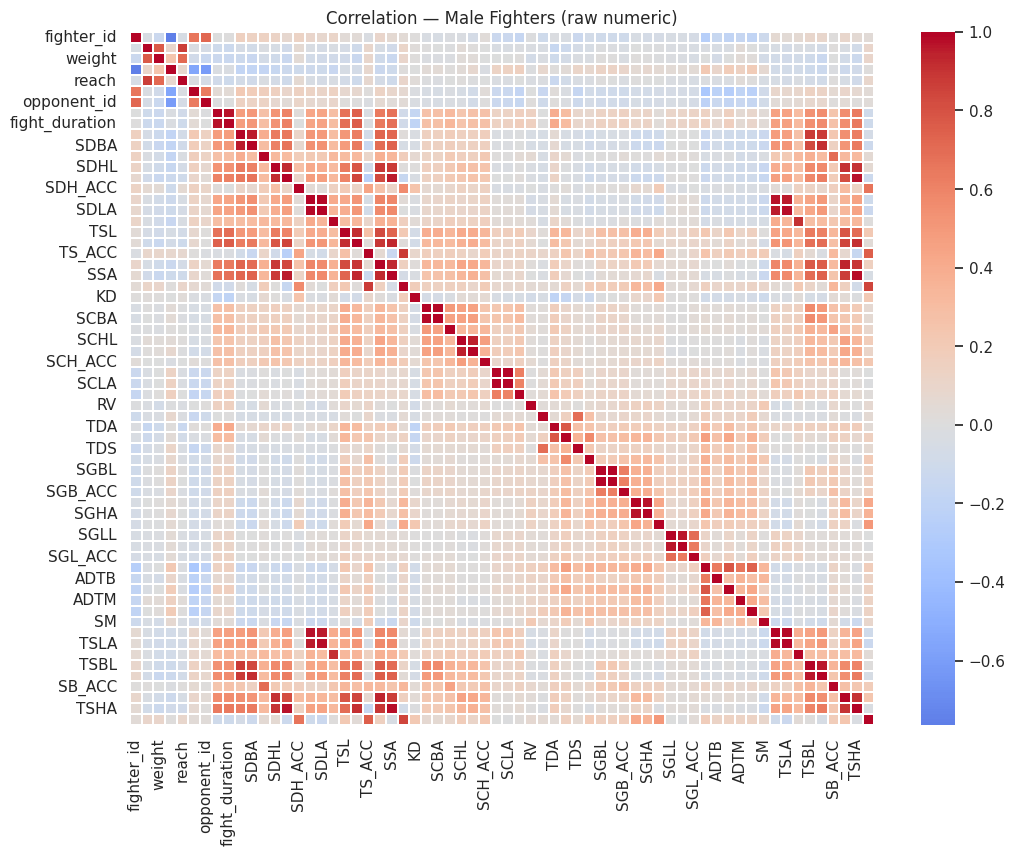

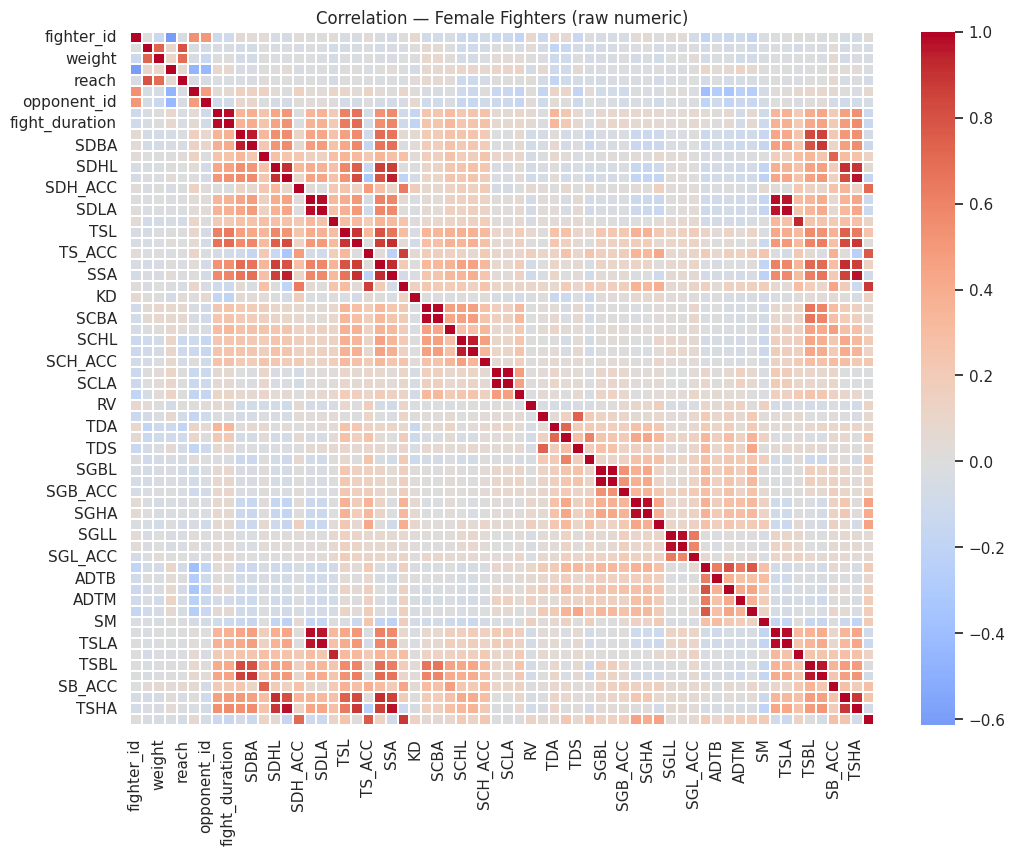

,feat1,feat2,abs_corr
1740,SGBL,SGBA,0.994371
1488,SCLL,SCLA,0.991143
1275,SCBL,SCBA,0.986028
1980,TSLL,TSLA,0.980342
840,SDLL,SDLA,0.979887
1194,SSA,TSHA,0.978632
927,SDLA,TSLA,0.976776
420,fight_end_round,fight_duration,0.972273
879,SDLL,TSLL,0.971572
1806,SGHL,SGHA,0.969234


,feat1,feat2,abs_corr
1488,SCLL,SCLA,0.994625
1740,SGBL,SGBA,0.989491
1275,SCBL,SCBA,0.986763
927,SDLA,TSLA,0.982502
1863,SGLL,SGLA,0.980599
420,fight_end_round,fight_duration,0.980335
1980,TSLL,TSLA,0.979176
879,SDLL,TSLL,0.979052
840,SDLL,SDLA,0.978935
1806,SGHL,SGHA,0.976398


In [ ]:
def corr_heatmap(df, title):
    num = df.select_dtypes(include=np.number)
    if num.shape[1] < 2:
        print('Not enough numeric columns for correlation.')
        return
    corr = num.corr()
    plt.figure(figsize=(12,9))
    sns.heatmap(corr, cmap='coolwarm', center=0, linewidths=.3)
    plt.title(title)
    plt.show()

def top_corr_pairs(df, threshold=0.8):
    num = df.select_dtypes(include=np.number)
    corr = num.corr().abs()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    pairs = upper.stack().reset_index()
    pairs.columns = ['feat1','feat2','abs_corr']
    return pairs[pairs['abs_corr'] > threshold].sort_values('abs_corr', ascending=False)

# Split by gender BEFORE encoding
male_df = combined_df[combined_df['gender'].str.lower()=='male'].copy() if 'gender' in combined_df.columns else combined_df.copy()
female_df = combined_df[combined_df['gender'].str.lower()=='female'].copy() if 'gender' in combined_df.columns else combined_df.iloc[0:0].copy()

corr_heatmap(male_df, 'Correlation — Male Fighters (raw numeric)')
corr_heatmap(female_df, 'Correlation — Female Fighters (raw numeric)')

display(top_corr_pairs(male_df, 0.8).head(20))
display(top_corr_pairs(female_df, 0.8).head(20))

## 7) Feature Prep Utility

In [ ]:
# Ensure event_date is in datetime format
df_fighter_history['event_date'] = pd.to_datetime(df_fighter_history['event_date'])

# Sort by fighter_id and then by event_date in ascending order
df_fighter_history_sorted = df_fighter_history.sort_values(by=['fighter_id', 'event_date'], ascending=True)

# Keep the last fight for each fighter (which will be the most recent after sorting)
df_most_recent_fight = df_fighter_history_sorted.drop_duplicates(subset=['fighter_id'], keep='last').copy()

print(f"Original number of rows in df_fighter_history: {len(df_fighter_history)}")
print(f"Number of rows after keeping only the most recent fight per fighter: {len(df_most_recent_fight)}")

display(df_most_recent_fight.head())

if RECENT:
  df_fighter_history = df_most_recent_fight

Original number of rows in df_fighter_history: 17837
Number of rows after keeping only the most recent fight per fighter: 3015


,uid,fight_id,event_id,event_date,event_name,promotion,fighter_id,fighter_name,fight_result,opponent_id,opponent_name,title_fight,fight_end_round,fight_result_type,fight_duration,over_2_5
7270,s:3301~l:3321~e:600013889~c:401407078,600013889-4421246-4350771,600013889,2022-03-05,UFC 272,UFC,2220951,greg hardy,L,4421246,serghei spivac,False,1,KO-TKO,2.27,False
1400,s:3301~l:3321~e:600054061~c:401777404,600054061-5060483-5101694,600054061,2025-07-12,UFC Fight Night,UFC,2223033,austen lane,L,5060483,vitor petrino,False,1,SUBMISSION,4.27,False
383,s:3301~l:3321~e:600053795~c:401767882,600053795-5078213-4028627,600053795,2025-06-21,UFC Fight Night,UFC,2312150,mohammed usman,W,5078213,hamdy abdelwahab,False,3,DEC-UNA,15.00,True
12216,s:3301~l:3321~e:600005500~c:401335213,600005500-3040385-2354193,600005500,2021-07-10,UFC 264,UFC,2335243,carlos condit,L,3040385,max griffin,False,3,DEC-UNA,15.00,True
16002,s:3301~l:3321~e:400252671~c:152682,400252671-2335530-2335788,400252671,2009-04-02,UFC Fight Night,UFC,2335256,carmelo marrero,L,2335530,ryan bader,False,3,DEC-UNA,15.00,True


In [ ]:
# Display a quick preview
display(df_fighter_history[['fight_id', 'fighter_id', 'fight_result']].head())

# Count how many times each fight_result appears
result_counts = df_fighter_history['fight_result'].value_counts(dropna=False)
print("Fight result counts:")
print(result_counts)

# Calculate percentages too
result_percent = df_fighter_history['fight_result'].value_counts(normalize=True, dropna=False) * 100
print("Fight result percentages (%):")
print(result_percent.round(2))

,fight_id,fighter_id,fight_result
7270,600013889-4421246-4350771,2220951,L
1400,600054061-5060483-5101694,2223033,L
383,600053795-5078213-4028627,2312150,W
12216,600005500-3040385-2354193,2335243,L
16002,400252671-2335530-2335788,2335256,L


Fight result counts:
fight_result
L    2435
W     542
D      38
Name: count, dtype: int64
Fight result percentages (%):
fight_result
L    80.76
W    17.98
D     1.26
Name: proportion, dtype: float64


In [ ]:
# Build combined_df (both sides present)

# 1) Normalize dtypes on relevant keys
for df in [df_fighter_history, df_fighter_attributes, df_fighter_stats]:
    for col in ['event_id', 'fighter_id', 'opponent_id', 'uid', 'fight_id']:
        if col in df.columns:
            df[col] = df[col].astype(str)

# 2) Use fighter_history as the base; keep only W/L; deduplicate conservative key
base = (
    df_fighter_history
      [df_fighter_history['fight_result'].isin(['W','L'])]
      .drop_duplicates(subset=['event_id', 'fighter_id', 'opponent_id'])
      .copy()
)

# 3) Add fighter attributes (height, reach, stance, etc.)
base = base.merge(
    df_fighter_attributes,
    on='fighter_id',
    how='left'
)

# 4) add per-fight stats
base = base.merge(
    df_fighter_stats,
    on=['uid', 'fighter_id'],
    how='left'
)

# 5) Pair winner/loser within the same event by swapping fighter/opponent ids
opp = base[['event_id', 'fighter_id', 'opponent_id', 'fight_result']].rename(
    columns={
        'fighter_id': 'opponent_id',
        'opponent_id': 'fighter_id',
        'fight_result': 'fight_result_opp'
    }
)

combined_df = base.merge(
    opp,
    on=['event_id', 'fighter_id', 'opponent_id'],
    how='inner',
    suffixes=('', '_opp')
)

# 6) Binary label for modeling
combined_df['fight_result_binary'] = (combined_df['fight_result'] == 'W').astype(int)

# 7) Sanity checks
print("Unique events:", combined_df['event_id'].nunique())
print("Rows:", len(combined_df))
print("Class counts:")
print(combined_df['fight_result'].value_counts())
print("Class balance (%):")
print((combined_df['fight_result'].value_counts(normalize=True) * 100).round(2))
display(combined_df[['event_id', 'fighter_id', 'opponent_id', 'fight_result', 'fight_result_opp']].head(10))

Unique events: 136
Rows: 732
Class counts:
fight_result
L    366
W    366
Name: count, dtype: int64
Class balance (%):
fight_result
L    50.0
W    50.0
Name: proportion, dtype: float64


,event_id,fighter_id,opponent_id,fight_result,fight_result_opp
0,600054061,2223033,5060483,L,W
1,600053795,2312150,5078213,W,L
2,401032731,2335449,2501238,W,L
3,400437518,2335467,2335748,W,L
4,400251738,2335472,2335522,L,W
5,400251738,2335522,2335472,W,L
6,401017344,2335524,2354057,W,L
7,400490714,2335526,2335527,W,L
8,400490714,2335527,2335526,L,W
9,600049124,2335639,2504951,W,L


fight_result
L    366
W    366
Name: count, dtype: int64


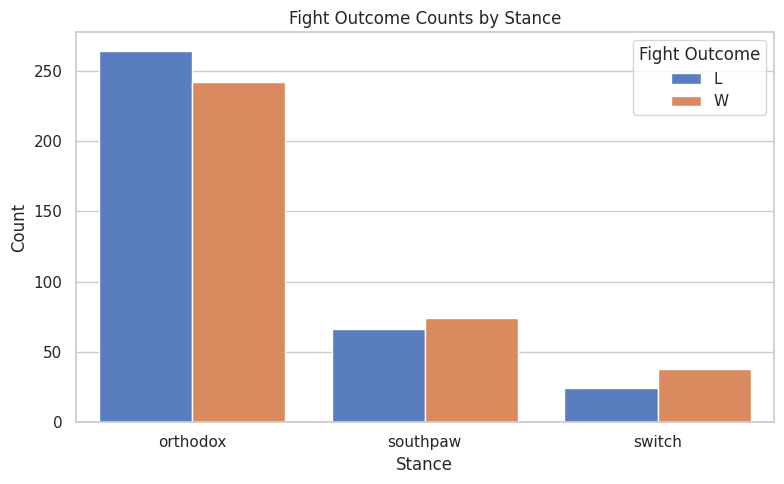

In [ ]:
print(combined_df['fight_result'].value_counts())

# --- Plot: Fight Outcomes by Stance ---
plt.figure(figsize=(8,5))
sns.countplot(
    data=combined_df,
    x='stance',
    hue='fight_result',
    palette='muted'
)
plt.title('Fight Outcome Counts by Stance')
plt.xlabel('Stance')
plt.ylabel('Count')
plt.legend(title='Fight Outcome', loc='best')
plt.tight_layout()
plt.show()

In [ ]:
ID_COLS = ['name','dob','uid','fight_id','event_date','event_name','fighter_name','opponent_name','fight_end_round']

def prepare_xy(df):
    """Clean frame, encode categoricals, create binary target from W/L.
    Returns X, y, feature_names.
    """
    # Keep only wins/losses for binary classification
    df = df[df['fight_result'].isin(['W','L'])].copy()
    df['y'] = (df['fight_result'] == 'W').astype(int)

    # Drop obvious identifiers
    df = df.drop(columns=[c for c in ID_COLS if c in df.columns], errors='ignore')

    # Separate types
    num = df.select_dtypes(include=np.number)
    cat = df.select_dtypes(include='object')
    if 'fight_result' in cat.columns:
        cat = cat.drop(columns=['fight_result'])

    # One‑hot encode categoricals (drop_first to avoid dummy trap)
    if cat.shape[1] > 0:
        df_enc = pd.get_dummies(cat, drop_first=True)
        X = pd.concat([num.drop(columns=['y'], errors='ignore'), df_enc], axis=1)
    else:
        X = num.drop(columns=['y'], errors='ignore')

    # Replace inf, then median‑impute leftover NaNs
    X = X.replace([np.inf, -np.inf], np.nan)
    for c in X.columns:
        if X[c].isna().any():
            X[c] = X[c].fillna(X[c].median())

    y = df['y']
    return X, y, X.columns.tolist()

## 8) Model Utility — Elastic Net Logistic Regression (CV)

In [ ]:
def fit_logistic_L2(X_train, y_train):
    """
    Fast L2-regularized logistic regression (no CV).
    Automatically drops fight_result_type_*, country_* and promotion_* columns.
    Returns: fitted pipeline, list of kept features.
    """
    # Drop unwanted columns
    cols_to_drop = [c for c in X_train.columns
                    if c.startswith("fight_result_") or c.startswith("country_") or c.startswith("promotion_") or c.startswith("opponent_") or c.startswith("event_") or c.startswith("fighter_id")]
    if cols_to_drop:
        print(f"Dropping {len(cols_to_drop)} columns: {cols_to_drop}")
        X_train = X_train.drop(columns=cols_to_drop, errors='ignore')

    pipe = make_pipeline(
        StandardScaler(),
        LogisticRegression(
            penalty='l2',
            C=1.0,
            solver='liblinear',
            max_iter=2000,
            random_state=42
        )
    )
    pipe.fit(X_train, y_train)
    return pipe, X_train.columns  # return model and final feature set


# --- Evaluation Function ---
def evaluate_model(pipe, X_test, y_test, feature_names, title_prefix=""):
    """Evaluate model performance and show top features."""
    # Ensure same columns in test as used in training
    X_test = X_test.loc[:, feature_names]

    logit = pipe.named_steps['logisticregression']

    # Predictions
    y_prob = pipe.predict_proba(X_test)[:, 1]
    y_pred = (y_prob >= 0.5).astype(int)

    # --- Metrics ---
    print(f"ROC-AUC: {roc_auc_score(y_test, y_prob):.3f}\n")
    print(classification_report(y_test, y_pred))

    # --- ROC Curve ---
    RocCurveDisplay.from_predictions(y_test, y_prob)
    plt.title(f"ROC Curve — {title_prefix}")
    plt.show()

    # --- Coefficients ---
    coefs = logit.coef_[0]
    coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefs})
    coef_df['AbsCoefficient'] = coef_df['Coefficient'].abs()
    coef_df = coef_df.sort_values('AbsCoefficient', ascending=False)

    print(f"\nTop 10 Most Influential Features — {title_prefix}")
    display(coef_df.head(10))

    # --- Bar Plot for Top Coefficients ---
    top = coef_df.head(10).iloc[::-1]  # reverse order for nicer plot
    plt.figure(figsize=(8, 6))
    plt.barh(top['Feature'], top['Coefficient'])
    plt.xlabel('Coefficient (log-odds impact)')
    plt.title(f'Top 10 Variables — {title_prefix}')
    plt.tight_layout()
    plt.show()

    return coef_df

In [ ]:
def run_gender_model(gender, combined_df):
    """
    Trains and evaluates a fast L2-regularized logistic regression model
    for the given gender ('male' or 'female').

    Steps:
      1. Filters combined_df for the given gender
      2. Prepares X, y using prepare_xy()
      3. Splits into train/test
      4. Trains model (fit_logistic_L2)
      5. Evaluates (evaluate_model)
      6. Returns coefficients dataframe
    """
    gender_lower = gender.lower()
    df = combined_df[combined_df['gender'].str.lower() == gender_lower].copy()
    print(f"\n{'='*80}\nRunning model for {gender.title()} Fighters ({len(df):,} rows)\n{'='*80}")

    # Prepare data
    X, y, feat = prepare_xy(df)

    # Split data
    Xtr, Xte, ytr, yte = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Fit model
    pipe, features = fit_logistic_L2(Xtr, ytr)

    # Evaluate
    coef_df = evaluate_model(pipe, Xte, yte, features, title_prefix=f"{gender.title()} Fighters")

## 9) Train & Evaluate — Male Model


Running model for Male Fighters (627 rows)
Dropping 1452 columns: ['fight_result_binary', 'event_id_400251790', 'event_id_400251919', 'event_id_400252023', 'event_id_400252069', 'event_id_400253667', 'event_id_400254052', 'event_id_400254696', 'event_id_400254794', 'event_id_400255359', 'event_id_400255423', 'event_id_400255445', 'event_id_400255493', 'event_id_400255552', 'event_id_400255576', 'event_id_400255591', 'event_id_400255609', 'event_id_400255653', 'event_id_400255669', 'event_id_400255678', 'event_id_400255685', 'event_id_400255697', 'event_id_400255701', 'event_id_400255710', 'event_id_400255712', 'event_id_400255714', 'event_id_400255726', 'event_id_400437518', 'event_id_400490714', 'event_id_400543516', 'event_id_400547234', 'event_id_400607619', 'event_id_400607638', 'event_id_400765682', 'event_id_400832048', 'event_id_400859828', 'event_id_400901153', 'event_id_400901155', 'event_id_400947051', 'event_id_400949207', 'event_id_400966346', 'event_id_400968458', 'event_

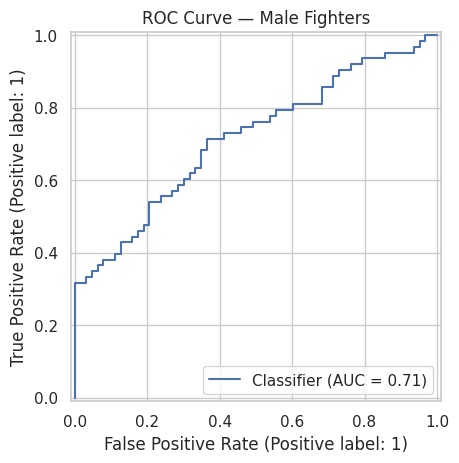


Top 10 Most Influential Features — Male Fighters


,Feature,Coefficient,AbsCoefficient
33,TDL,1.328375,1.328375
14,TSL,1.321339,1.321339
20,KD,1.103539,1.103539
32,TDA,-1.101650,1.101650
81,style_kickboxing,-1.070096,1.070096
39,SGHL,0.995299,0.995299
17,SSL,0.948312,0.948312
29,SCL_ACC,-0.869032,0.869032
23,SCB_ACC,0.856424,0.856424
9,SDHA,-0.832776,0.832776


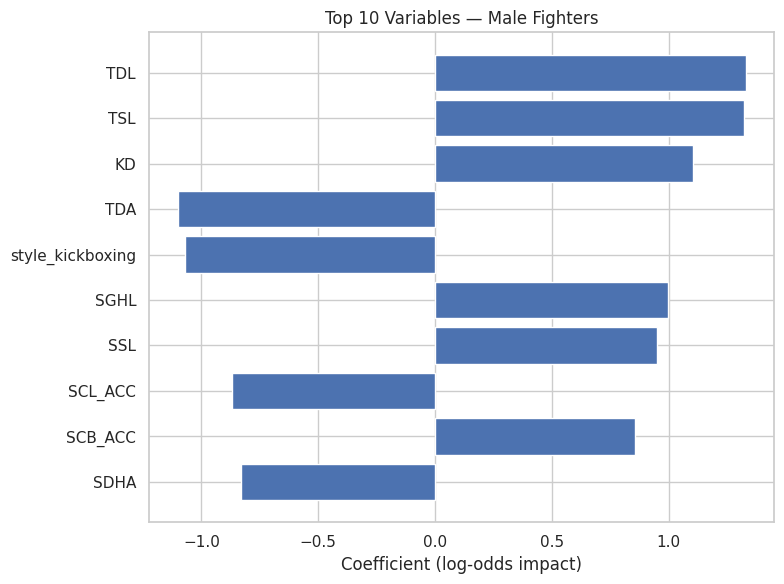

In [ ]:
coef_male = run_gender_model("male", combined_df)

## 10) Train & Evaluate — Female Model


Running model for Female Fighters (105 rows)
Dropping 276 columns: ['fight_result_binary', 'event_id_401074498', 'event_id_401128924', 'event_id_600000637', 'event_id_600010587', 'event_id_600011067', 'event_id_600019227', 'event_id_600021772', 'event_id_600032692', 'event_id_600037292', 'event_id_600039754', 'event_id_600039853', 'event_id_600047781', 'event_id_600051444', 'event_id_600051446', 'event_id_600053073', 'event_id_600053165', 'event_id_600053168', 'event_id_600053312', 'event_id_600053455', 'event_id_600053545', 'event_id_600053606', 'event_id_600053664', 'event_id_600053672', 'event_id_600053676', 'event_id_600053732', 'event_id_600053795', 'event_id_600053891', 'event_id_600054045', 'event_id_600054061', 'event_id_600054244', 'event_id_600054396', 'event_id_600054419', 'event_id_600055007', 'event_id_600055032', 'event_id_600055226', 'event_id_600055487', 'promotion_UFC', 'fighter_id_2553021', 'fighter_id_2554705', 'fighter_id_2951361', 'fighter_id_3024395', 'fighter_id

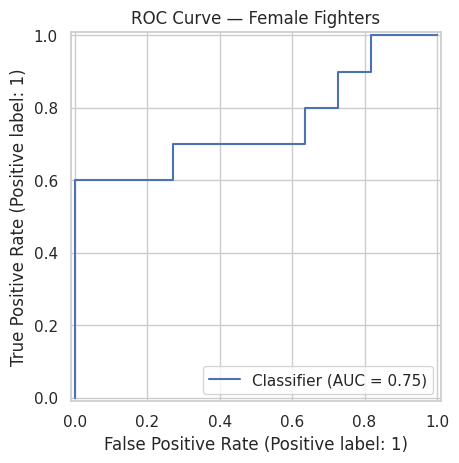


Top 10 Most Influential Features — Female Fighters


,Feature,Coefficient,AbsCoefficient
38,SGB_ACC,-0.741817,0.741817
116,gym_marajo brothers team,-0.702165,0.702165
130,gym_pura vida bjj,-0.660494,0.660494
33,TDL,0.600496,0.600496
90,gym_chute boxe,0.596895,0.596895
39,SGHL,0.580790,0.580790
60,weight_class_womens-featherweight,0.577703,0.577703
3,age,-0.503302,0.503302
105,gym_grappling krakow,0.503057,0.503057
76,style_striker,0.485473,0.485473


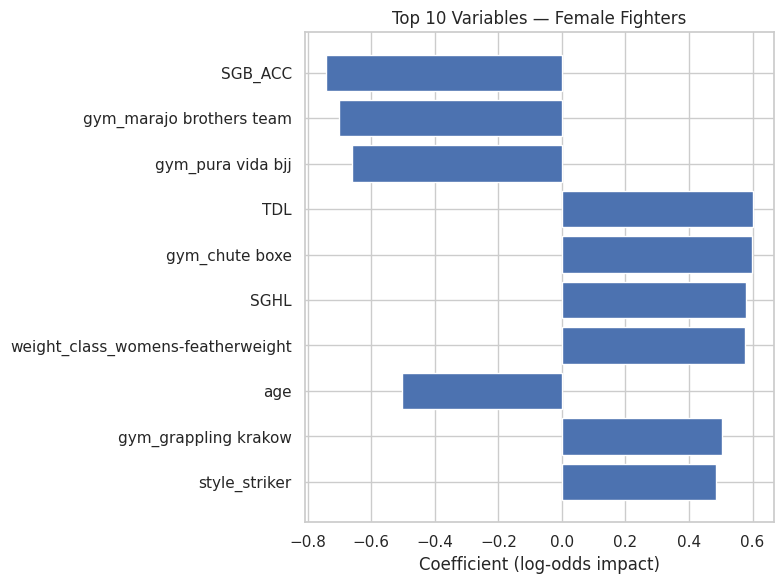

In [ ]:
coef_female = run_gender_model("female", combined_df)

## 11) Notes & Limitations
- Coefficients show **associations** (not causation).
- Elastic Net mitigates **multicollinearity**; remaining interactions are still linear in log‑odds.
- Consider comparing against tree‑based models (XGBoost/LightGBM) for non‑linear interactions and potentially higher AUC.
